## Hyperparameter Optimization

In [1]:

import string
import re
import nltk
nltk.download(["stopwords"])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess(text):
    cleaned_text = text.translate(str.maketrans('', '', '!"#$%&\'()*+,.<=>?@[]^`{|}~' + u'\xa0'))
    cleaned_text = cleaned_text.lower()
    cleaned_text = cleaned_text.translate(str.maketrans(string.whitespace, ' ' * len(string.whitespace), ''))
    cleaned_text = ' '.join(['_variable_with_underscore' if '_' in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_variable_with_dash' if '-' in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_long_variable_name' if len(t) > 15 and t[0] != '#' else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_weburl' if t.startswith('http') and '/' in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_number' if re.sub('[\\/;:_-]', '', t).isdigit() else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_variable_with_address' if re.match('.*0x[0-9a-f].*', t) else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_name_with_number' if re.match('.*[a-f]*:[0-9]*', t) else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_number_starts_with_one_character' if re.match('[a-f][0-9].*', t) else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_number_starts_with_three_characters' if re.match('[a-f]{3}[0-9].*', t) else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_version' if any(i.isdigit() for i in t) and t.startswith('v') else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_localpath' if ('\\' in t or '/' in t) and ':' not in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_image_size' if t.endswith('px') else t for t in cleaned_text.split()])
    tokenized_text = word_tokenize(cleaned_text)
    sw_removed_text = [word for word in tokenized_text if word not in stopword_set]
    sw_removed_text = [word for word in sw_removed_text if len(word) > 2]
    stemmed_text = ' '.join([stemmer.stem(w) for w in sw_removed_text])
    return stemmed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thanatornkanthala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from multiprocessing.pool import ThreadPool as Pool
import pandas as pd

def initialize_pool(stopwords, ps):
    global stopword_set
    global stemmer
    stopword_set = stopwords
    stemmer = ps

dataset = pd.read_json('data/embold_train.json')
dataset.loc[dataset['label'] > 0, 'label'] = -1
dataset.loc[dataset['label'] == 0, 'label'] = 1
dataset.loc[dataset['label'] == -1, 'label'] = 0
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()
pool = Pool(8, initializer=initialize_pool, initargs=(stopwords, ps, ))

cleaned_title = pool.map(preprocess, dataset.title)
cleaned_body = pool.map(preprocess, dataset.body)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

data_texts = pd.DataFrame([cleaned_title, cleaned_body], index=["title", "body"]).T
y = dataset["label"]
data_fit, data_blindtest, y_fit, y_blindtest = train_test_split(data_texts, y, test_size=0.1)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer.fit(cleaned_title + cleaned_body)

X_tfidf_fit = tfidf_vectorizer.transform(data_fit["title"])
X_tfidf_blindtest = tfidf_vectorizer.transform(data_blindtest["title"])

In [4]:
from sklearn import model_selection
import lightgbm as lgb

gbm_model = lgb.LGBMClassifier()

precision_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean()

print('CV: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

[LightGBM] [Info] Number of positive: 48117, number of negative: 59883[LightGBM] [Info] Number of positive: 48117, number of negative: 59883

[LightGBM] [Info] Number of positive: 48117, number of negative: 59883
[LightGBM] [Info] Number of positive: 48117, number of negative: 59883
[LightGBM] [Info] Number of positive: 48116, number of negative: 59884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.479068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117994
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 2290
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445528 -> initscore=-0.218757
[LightGBM] [Info] Start training from score -0.218757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.707882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118140
[LightGBM] [Info] N

In [5]:
from sklearn import model_selection, metrics

data_fit_train, data_fit_test, y_fit_train, y_fit_test = model_selection.train_test_split(data_fit, y_fit, test_size=0.3)

X_tfidf_fit_train = tfidf_vectorizer.transform(data_fit_train['title'])
X_tfidf_fit_test = tfidf_vectorizer.transform(data_fit_test['title'])
X_tfidf_blindtest = tfidf_vectorizer.transform(data_blindtest['title'])

gbm_model.fit(X_tfidf_fit_train, y_fit_train, eval_set=[(X_tfidf_fit_test, y_fit_test)], eval_metric='AUC')

precision_test_score = metrics.precision_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')
recall_test_score = metrics.recall_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')
f1_test_score = metrics.f1_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')

print('test: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_test_score, recall_test_score, f1_test_score))

[LightGBM] [Info] Number of positive: 42029, number of negative: 52471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105646
[LightGBM] [Info] Number of data points in the train set: 94500, number of used features: 2145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444751 -> initscore=-0.221901
[LightGBM] [Info] Start training from score -0.221901
test: p:0.7417 r:0.7644 f:0.7445


In [6]:
import optuna
import numpy as np

def objective(trial):
    dtrain = lgb.Dataset(X_tfidf_fit_train, label=y_fit_train)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_tfidf_fit_test)
    pred_labels = np.rint(preds)
    accuracy = metrics.roc_auc_score(y_fit_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

/Users/thanatornkanthala/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-09 13:57:36,738] A new study created in memory with name: no-name-af6ae256-e226-46c1-b08c-482e9c1359b6
[I 2024-03-09 13:57:46,047] Trial 0 finished with value: 0.7501861476332001 and parameters: {'lambda_l1': 3.5367276724838396e-06, 'lambda_l2': 7.982461664150587e-08, 'num_leaves': 241, 'feature_fraction': 0.8514349516360837, 'bagging_fraction': 0.49104742771900767, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 0 with value: 0.7501861476332001.
[I 2024-03-09 13:57:51,033] Trial 1 finished with value: 0.7387520921009817 and parameters: {'lambda_l1': 3.90625430058955e-06, 'lambda_l2': 5.810443119133052e-07, 'num_leaves': 125, 'feature_fraction': 0.9301789486092297, 'bagging_fraction': 0.402221147843

In [7]:
best_params = study.best_params
gbm_model = lgb.LGBMClassifier(**best_params)

precision_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean()

print('CV: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

gbm_model.fit(X_tfidf_fit_train, y_fit_train, eval_set=[(X_tfidf_fit_test, y_fit_test)], eval_metric='AUC')

precision_test_score = metrics.precision_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')
recall_test_score = metrics.recall_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')
f1_test_score = metrics.f1_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')

print('test: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_test_score, recall_test_score, f1_test_score))

[LightGBM] [Warning] lambda_l1 is set=6.702402569232983e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.702402569232983e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6867214598752384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6867214598752384
[LightGBM] [Warning] bagging_fraction is set=0.9096395779799096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9096395779799096
[LightGBM] [Warning] lambda_l2 is set=0.0003466316295254472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003466316295254472
[LightGBM] [Warning] lambda_l1 is set=6.702402569232983e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.702402569232983e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6867214598752384, 

## In Class Activity

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

count_vectorizer = CountVectorizer(ngram_range=(1,1))
count_vectorizer.fit(cleaned_title + cleaned_body)


data_fit_train, data_fit_test, y_fit_train, y_fit_test = model_selection.train_test_split(data_fit, y_fit, test_size=0.3)

X_tf_fit_train = count_vectorizer.transform(data_fit_train['title'])
X_tf_fit_test = count_vectorizer.transform(data_fit_test['title'])
X_tf_blindtest = count_vectorizer.transform(data_blindtest['title'])

lda = LatentDirichletAllocation(n_components=500, random_state=0)
lda.fit(X_tf_fit_train)
X_lda_fit = lda.transform(X_tf_fit_train)
gbm_model_with_lda = lgb.LGBMClassifier()

precision_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_lda_fit, y_fit_train, cv=5,
n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_lda_fit, y_fit_train, cv=5,
n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_lda_fit, y_fit_train, cv=5, n_jobs=-2,
scoring='f1_macro').mean()

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

X_tfidf_fit_train = tfidf_vectorizer.transform(data_fit_train['title'])
X_fit_with_lda = hstack([X_tfidf_fit_train, X_lda_fit]).tocsr()

precision_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_fit_with_lda, y_fit_train, cv=5,
n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_fit_with_lda, y_fit_train, cv=5,
n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_fit_with_lda, y_fit_train, cv=5,
n_jobs=-2, scoring='f1_macro').mean()

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127459
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Number of positive: 33714, number of negative: 41886
[LightGBM] [Info] Number of positive: 33714, number of negative: 41886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127459
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 50

In [22]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_components = trial.suggest_int('n_components', 2, 500)
    learning_decay = trial.suggest_float('learning_decay', 0.5, 1.0)
    
    lda = LatentDirichletAllocation(n_components=n_components, learning_decay=learning_decay, random_state=0)
    lda.fit(X_tf_fit_train)
    X_lda_fit = lda.transform(X_tf_fit_train)
    
    gbm_model_with_lda = lgb.LGBMClassifier()
    score = cross_val_score(gbm_model_with_lda, X_lda_fit, y_fit_train, cv=5, scoring='f1_macro', verbose=0).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-03-09 15:11:24,808] A new study created in memory with name: no-name-b02a20b8-9aa6-4381-88f4-5a842e32bf17


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16830
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16830
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM]

[I 2024-03-09 15:12:05,037] Trial 0 finished with value: 0.619762275907522 and parameters: {'n_components': 66, 'learning_decay': 0.7282744881934979}. Best is trial 0 with value: 0.619762275907522.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112146
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112147
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 440
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[Light

[I 2024-03-09 15:13:52,417] Trial 1 finished with value: 0.7073239891089804 and parameters: {'n_components': 440, 'learning_decay': 0.7900190349207263}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM]

[I 2024-03-09 15:14:37,156] Trial 2 finished with value: 0.6167629083768359 and parameters: {'n_components': 96, 'learning_decay': 0.5863020022513143}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM]

[I 2024-03-09 15:15:21,194] Trial 3 finished with value: 0.6174270359660184 and parameters: {'n_components': 88, 'learning_decay': 0.9152318322804427}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33150
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33150
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGB

[I 2024-03-09 15:16:12,673] Trial 4 finished with value: 0.6118712282016608 and parameters: {'n_components': 130, 'learning_decay': 0.8409859515037036}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80580
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80580
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGB

[I 2024-03-09 15:17:33,211] Trial 5 finished with value: 0.6757528346987612 and parameters: {'n_components': 316, 'learning_decay': 0.5338989616004632}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94860
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94860
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGB

[I 2024-03-09 15:19:02,396] Trial 6 finished with value: 0.6822096408995288 and parameters: {'n_components': 372, 'learning_decay': 0.940348183964075}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78030
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 306
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78030
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 306
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGB

[I 2024-03-09 15:20:22,089] Trial 7 finished with value: 0.6581199218230525 and parameters: {'n_components': 306, 'learning_decay': 0.9914480964348377}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73440
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73440
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGB

[I 2024-03-09 15:21:37,947] Trial 8 finished with value: 0.6652741758511975 and parameters: {'n_components': 288, 'learning_decay': 0.6843080381462909}. Best is trial 1 with value: 0.7073239891089804.


[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64770
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGBM] [Info] Number of positive: 33713, number of negative: 41887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64770
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445939 -> initscore=-0.217092
[LightGBM] [Info] Start training from score -0.217092
[LightGB

[I 2024-03-09 15:22:49,590] Trial 9 finished with value: 0.6386583956220433 and parameters: {'n_components': 254, 'learning_decay': 0.956545038403525}. Best is trial 1 with value: 0.7073239891089804.


In [24]:
best_params = study.best_params
gbm_model = lgb.LGBMClassifier(**best_params)

precision_cv_score = model_selection.cross_val_score(gbm_model, X_lda_fit, y_fit_train, cv=5, n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model, X_lda_fit, y_fit_train, cv=5, n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model, X_lda_fit, y_fit_train, cv=5, n_jobs=-2, scoring='f1_macro').mean()

print('CV: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))


X_lda_fit_test = lda.transform(X_tf_fit_test)
gbm_model.fit(X_lda_fit, y_fit_train, eval_set=[(X_lda_fit_test, y_fit_test)], eval_metric='AUC')

X_lda_blindtest = lda.transform(X_tf_blindtest)

precision_test_score = metrics.precision_score(gbm_model.predict(X_lda_blindtest), y_blindtest, average='macro')
recall_test_score = metrics.recall_score(gbm_model.predict(X_lda_blindtest), y_blindtest, average='macro')
f1_test_score = metrics.f1_score(gbm_model.predict(X_lda_blindtest), y_blindtest, average='macro')

print('test: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_test_score, recall_test_score, f1_test_score))

[LightGBM] [Warning] Unknown parameter: n_components
[LightGBM] [Warning] Unknown parameter: learning_decay
[LightGBM] [Warning] Unknown parameter: n_components
[LightGBM] [Warning] Unknown parameter: learning_decay
[LightGBM] [Warning] Unknown parameter: n_components
[LightGBM] [Warning] Unknown parameter: learning_decay
[LightGBM] [Warning] Unknown parameter: n_components
[LightGBM] [Warning] Unknown parameter: learning_decay
[LightGBM] [Warning] Unknown parameter: n_components
[LightGBM] [Warning] Unknown parameter: learning_decay
[LightGBM] [Warning] Unknown parameter: n_components
[LightGBM] [Warning] Unknown parameter: learning_decay
[LightGBM] [Info] Number of positive: 33714, number of negative: 41886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: n_components
[LightGBM] [Warning] Unknown parameter: learning_decay
[LightGBM] 

## Learn to Rank

In [10]:
import pandas as pd

anime = pd.read_csv("./data/anime.csv")
rating = pd.read_csv("./data/rating_complete.csv")

anime_features = [
    'MAL_ID', 'English name', 'Japanese name', 'Score', 'Genres', 'Popularity',
    'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
    'Score-1', 'Score-2', 'Score-3', 'Score-4', 'Score-5',
    'Score-6', 'Score-7', 'Score-8', 'Score-9', 'Score-10'
]
anime = anime[anime_features]

merged_df = anime.merge(rating, left_on='MAL_ID', right_on='anime_id', how='inner')
genre_names = [
    'Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi',
    'Game', 'Space', 'Music', 'Mystery', 'School', 'Fantasy',
    'Horror', 'Kids', 'Sports', 'Magic', 'Romance'
]

In [11]:
def genre_to_category(df):
    '''Add genre cagegory column'''
    d = {name :[] for name in genre_names}

    def f(row):
        genres = row.Genres.split(',')
        for genre in genre_names:
            if genre in genres:
                d[genre].append(1)
            else:
                d[genre].append(0)

    # create genre category dict
    df.apply(f, axis=1)

    # add genre category
    genre_df = pd.DataFrame(d, columns=genre_names)
    df = pd.concat([df, genre_df], axis=1)
    return df

def make_anime_feature(df):
    # convert object to a numeric type, replacing Unknown with nan.
    df['Score'] = df['Score'].apply(lambda x: np.nan if x=='Unknown' else float(x))
    for i in range(1, 11):
        df[f'Score-{i}'] = df[f'Score-{i}'].apply(lambda x: np.nan if x=='Unknown' else float(x))

    # add genre ctegory columns
    df = genre_to_category(df)

    return df

In [12]:
def make_user_feature(df):
    # add user feature
    df['rating_count'] = df.groupby('user_id')['anime_id'].transform('count')
    df['rating_mean'] = df.groupby('user_id')['rating'].transform('mean')
    return df

def preprocess(merged_df):
    merged_df = make_anime_feature(merged_df)
    merged_df = make_user_feature(merged_df)
    return merged_df

merged_df = preprocess(merged_df)
merged_df = merged_df.drop(['MAL_ID', 'Genres'], axis=1)
merged_df.head()

,English name,Japanese name,Score,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,...,Mystery,School,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,Cowboy Bebop,カウボーイビバップ,8.78,39,1251960,61971,105808,718161,71513,26678,...,0,0,0,0,0,0,0,0,315,7.603175
1,Cowboy Bebop,カウボーイビバップ,8.78,39,1251960,61971,105808,718161,71513,26678,...,0,0,0,0,0,0,0,0,311,7.073955
2,Cowboy Bebop,カウボーイビバップ,8.78,39,1251960,61971,105808,718161,71513,26678,...,0,0,0,0,0,0,0,0,96,7.656250
3,Cowboy Bebop,カウボーイビバップ,8.78,39,1251960,61971,105808,718161,71513,26678,...,0,0,0,0,0,0,0,0,679,7.540501
4,Cowboy Bebop,カウボーイビバップ,8.78,39,1251960,61971,105808,718161,71513,26678,...,0,0,0,0,0,0,0,0,63,8.269841


In [13]:
fit, blindtest = train_test_split(merged_df, test_size=0.2, random_state=0)
fit_train, fit_test = train_test_split(fit, test_size=0.3, random_state=0)

features = ['Score', 'Popularity','Members',
            'Favorites','Watching','Completed','On-Hold','Dropped',
            'Score-1','Score-2','Score-3','Score-4','Score-5',
            'Score-6','Score-7','Score-8','Score-9','Score-10',
            'rating_count','rating_mean']
features += genre_names
user_col = 'user_id'
item_col = 'anime_id'
target_col = 'rating'

fit_train = fit_train.sort_values('user_id').reset_index(drop=True)
fit_test = fit_test.sort_values('user_id').reset_index(drop=True)
blindtest = blindtest.sort_values('user_id').reset_index(drop=True)

# Model query data
fit_train_query = fit_train[user_col].value_counts().sort_index()
fit_test_query = fit_test[user_col].value_counts().sort_index()
blindtest_query = blindtest[user_col].value_counts().sort_index()


In [19]:
model = lgb.LGBMRanker(n_estimators=1000, random_state=0)
model.fit(
    fit_train[features],
    fit_train[target_col],
    group=fit_train_query,
    eval_set=[(fit_test[features], fit_test[target_col])],
    eval_group=[list(fit_test_query)],
    eval_at=[1, 3, 5, 10],  # calc validation ndcg@1,3,5,10
    # early_stopping_rounds=100,
    # verbose=10
    callbacks=[
        lgb.callback.early_stopping(100),
    ],
)

#%%
model.predict(blindtest.iloc[:10][features])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 32274635, number of used features: 36
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[733]	valid_0's ndcg@1: 0.713589	valid_0's ndcg@3: 0.723082	valid_0's ndcg@5: 0.739184	valid_0's ndcg@10: 0.773832


array([ 0.08830729, -1.9089911 , -2.40144488, -0.84965541,  0.04302394,
        0.20422849, -0.78542115,  0.25960152,  0.48935606, -0.48269437])

Text(0.5, 1.0, 'Feature Importance')

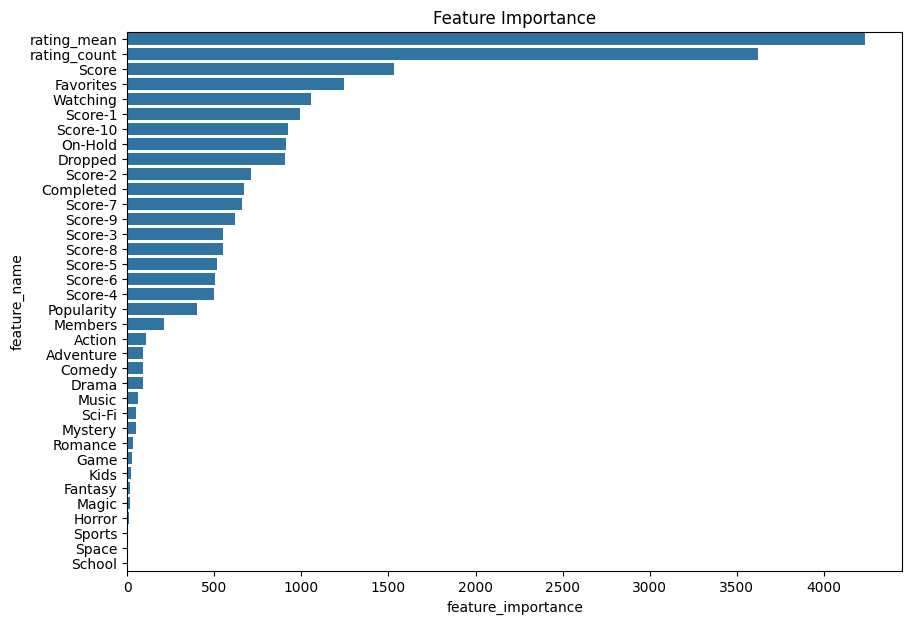

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns

# Feature importance
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('Feature Importance')


In [24]:
def predict(user_df, top_k, anime, rating):
    user_anime_df = anime.merge(user_df, left_on='MAL_ID', right_on='anime_id')
    user_anime_df = make_anime_feature(user_anime_df)

    excludes_genres = list(np.array(genre_names)[np.nonzero([user_anime_df[genre_names].sum(axis=0) <= 1])[1]])

    pred_df = make_anime_feature(anime.copy())
    pred_df = pred_df.loc[pred_df[excludes_genres].sum(axis=1) == 0]

    for col in user_df.columns:
        if col in features:
            pred_df[col] = user_df[col].values[0]

    preds = model.predict(pred_df[features])

    topk_idx = np.argsort(preds)[::-1][:top_k]

    recommend_df = pred_df.iloc[topk_idx].reset_index(drop=True)

    # Check recommendation
    print('---------- Recommend ----------')
    for i, row in recommend_df.iterrows():
        print(f'{i+1}: {row["Japanese name"]}:{row["English name"]}')

    print('---------- Rated ----------')
    user_df = user_df.merge(anime, left_on='anime_id', right_on='MAL_ID', how='inner')
    for i, row in user_df.sort_values('rating', ascending=False).iterrows():
        print(f'rating:{row["rating"]}: {row["Japanese name"]}:{row["English name"]}')

    return recommend_df

In [25]:
rating.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [26]:
user_id = 0
user_df = rating.copy().loc[rating['user_id'] == user_id]
user_df = make_user_feature(user_df)
predict(user_df, 10, anime, rating)

---------- Recommend ----------
1: 銀魂 THE FINAL:Unknown
2: 銀河英雄伝説:Legend of the Galactic Heroes
3: 僕のヒーローアカデミア THE MOVIE 3:Unknown
4: 小林さんちのメイドラゴンS:Unknown
5: 鬼滅の刃 遊郭編:Unknown
6: あしたのジョー２:Rocky Joe 2
7: ぴったんこ!! ねこざかな:Unknown
8: 銀魂°:Gintama Season 4
9: イジらないで、長瀞さん:Ijiranaide, Nagatoro San
10: 進撃の巨人 The Final Season:Attack on Titan Final Season
---------- Rated ----------
rating:10: ゴーストハント:Ghost Hunt
rating:10: 時をかける少女:The Girl Who Leapt Through Time
rating:10: ホーホケキョ となりの山田くん:My Neighbors the Yamadas
rating:10: 火垂るの墓:Grave of the Fireflies
rating:9: 劇場版 鋼の錬金術師 シャンバラを征く者:Fullmetal Alchemist:The Movie - Conqueror of Shamballa
rating:9: ONE PIECE:Unknown
rating:9: Fate/stay night:Fate/stay night
rating:9: 鋼の錬金術師:Fullmetal Alchemist
rating:9: ジャングルの王者ターちゃん:Unknown
rating:9: 伊賀野カバ丸:Unknown
rating:8: SAMURAI DEEPER KYO:Samurai Deeper Kyo
rating:8: ラブ★コン:Lovely Complex
rating:8: ハウルの動く城:Howl's Moving Castle
rating:8: もののけ姫:Princess Mononoke
rating:8: 千と千尋の神隠し:Spirited Away
rating:7: ゲド戦記:Tale

,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Mystery,School,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,39486,Unknown,銀魂 THE FINAL,8.88,"Action, Sci-Fi, Comedy, Historical, Parody, Dr...",2987,29811,902,1465,2640,...,0,0,0,0,0,0,0,0,35,7.4
1,820,Legend of the Galactic Heroes,銀河英雄伝説,9.07,"Military, Sci-Fi, Space, Drama",633,230168,13834,25968,52583,...,0,0,0,0,0,0,0,0,35,7.4
2,44200,Unknown,僕のヒーローアカデミア THE MOVIE 3,NaN,"Action, Comedy, Super Power, School, Shounen",2501,41961,195,0,3,...,0,0,0,0,0,0,0,0,35,7.4
3,39247,Unknown,小林さんちのメイドラゴンS,NaN,"Slice of Life, Comedy, Fantasy",1346,106489,627,4,1,...,0,0,0,0,0,0,0,0,35,7.4
4,47778,Unknown,鬼滅の刃 遊郭編,NaN,"Action, Historical, Demons, Supernatural, Shounen",2078,59440,547,17,3,...,0,0,0,0,0,0,0,0,35,7.4
5,2921,Rocky Joe 2,あしたのジョー２,8.67,"Action, Drama, Shounen, Slice of Life, Sports",2966,30192,1546,1378,14113,...,0,0,0,0,0,0,0,0,35,7.4
6,40089,Unknown,ぴったんこ!! ねこざかな,NaN,Unknown,12638,412,0,198,0,...,0,0,0,0,0,0,0,0,35,7.4
7,28977,Gintama Season 4,銀魂°,9.10,"Action, Comedy, Historical, Parody, Samurai, S...",329,404121,11868,48011,167130,...,0,0,0,0,0,0,0,0,35,7.4
8,42361,"Ijiranaide, Nagatoro San",イジらないで、長瀞さん,NaN,"Slice of Life, Comedy, Romance",1784,73950,756,9,2,...,0,0,0,0,0,0,0,0,35,7.4
9,40028,Attack on Titan Final Season,進撃の巨人 The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",119,733260,44862,566239,553,...,0,0,0,0,0,0,0,0,35,7.4
